In [1]:
import numpy as np
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 2))
sys.path.insert(0, BASE_DIR)

from setting import plt
from giefstat.estimate.quant_based._quant_darbellay import exec_partition, Cell
from giefstat.util import stdize_values
from dataset.bivariate.data_generator import gen_dataset

Use environmental variables in default.yml


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


定义如下基于离散化结果的互信息计算式:

In [2]:
def cal_mi(x: np.ndarray, y: np.ndarray):
    """计算互信息
    :param x: 变量X的数据
    :param y: 变量Y的数据
    """
    leaf_cells, arr_norm = exec_partition(x, y)
    N_total, _ = arr_norm.shape
    
    # 计算互信息.
    n_leafs = len(leaf_cells)

    mi = 0.0
    for i in range(n_leafs):
        cell = leaf_cells[i]  # type: Cell
        (xl, xu), (yl, yu) = cell.bounds

        Nxy = len(cell.arr)
        Nx = len(
            np.where((arr_norm[:, 0] >= xl) & (arr_norm[:, 0] < xu))[0])
        Ny = len(
            np.where((arr_norm[:, 1] >= yl) & (arr_norm[:, 1] < yu))[0])
        gain = Nxy * np.log(Nxy / Nx / Ny)
        mi += gain

    mi = round(mi / N_total + np.log(N_total), 2)
    return mi

对Darbellay离散化效果进行展示:

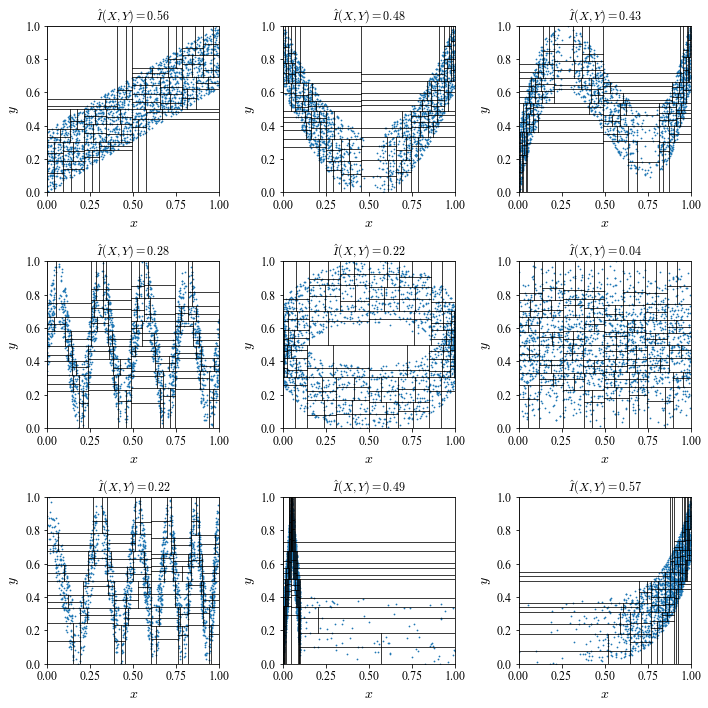

In [3]:
funcs = ["line", "parabola", "cubic", "sin_low_freq", "circular", "random", "vary_freq_cos", "spike", "exp_base_2"]
N_total = 2000

amp = 0.3  # 噪声
plt.figure(figsize=[10, 10])
for i, func in enumerate(funcs):
    x, y = gen_dataset(func, N_total)

    y_range = np.max(y) - np.min(y)
    noise = np.random.uniform(-amp * y_range, amp * y_range, y.shape)
    y_noise = y.copy() + noise
    
    x, y_noise = stdize_values(x, "c"), stdize_values(y_noise, "c")

    # 计算互信息

    mi = cal_mi(x, y_noise)

    # ---- 3. 画图 ------------------------------------------------------------------------------

    leaf_cells, arr_norm = exec_partition(x, y_noise)

    plt.subplot(3, 3, i + 1)
    pdf_ub = max(c.cal_proba_dens(N_total) for c in leaf_cells)
    for c in leaf_cells:
        c.show()
    plt.scatter(arr_norm[:, 0], arr_norm[:, 1], marker="o", linewidths=0.01, s=3, alpha=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title(f"$\\hat I(X,Y) = {mi}$")
plt.tight_layout()